# Project part A

Imports

In [3]:
import urllib.request
import urllib.parse
import json
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
from tqdm.asyncio import trange, tqdm
import asyncio
import aiohttp  # requires cchardet package

plt.rcParams['figure.figsize'] = [10, 8]

If something related to tqdm fails, run:
> `pip install ipywidgets widgetsnbextension pandas-profiling`

## Downloading the data

In [4]:
## Util functions ##

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def flatten(l):
    return [item for sublist in l for item in sublist]

## Data download ##

# Category pages

def get_category_pages_query(title, namespace_id=0):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=categorymembers"
    dataformat ="format=json&cmlimit=500"
    safe_title = "cmtitle=" + urllib.parse.quote_plus(title)
    cmnamespace = "cmnamespace=" + str(namespace_id)

    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, safe_title, cmnamespace, dataformat)

    return query

def handle_category_pages_return(wikitext_json):

    categories_list = wikitext_json["query"]["categorymembers"]

    if "continue" in wikitext_json:
        contin = wikitext_json["continue"]["cmcontinue"]
    else:
        contin = None

    return contin, categories_list

# Title search

def get_wiki_pages_with_prefix_query(prefix, namespace_id=0):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=allpages"
    dataformat ="format=json&aplimit=500"
    apprefix = "apprefix=" + urllib.parse.quote_plus(prefix)
    apnamespace = "apnamespace=" + str(namespace_id)

    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, apprefix, apnamespace, dataformat)

    return query

def handle_wiki_pages_with_prefix_return(wikitext_json):

    title_list_raw = wikitext_json["query"]["allpages"]

    if len(title_list_raw) > 0:
        title_list = [entry["title"] for entry in title_list_raw]
    else:
        title_list = []

    return None, title_list

# Wiki pages

def get_wiki_data_query(titles):
    # Can handle multiple titles
    if isinstance(titles, list):
        titlestring = "|".join(titles)
    else:
        titlestring = titles

    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    safe_title = "titles=" + urllib.parse.quote_plus(titlestring)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    return query

def handle_wiki_data_return(wikitext_json):

    pages = wikitext_json["query"]["pages"]

    return None, pages

# HTTP Request handling

def send_urlib_request_sync(query):
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    return wikitext_json

async def send_urlib_request_async(query, response_handler=None, query_continue_param=None):
    # response_handler callback functions should return a continue indicator as first argument, which will trigger another query if it is not None, and the actual return as a second argument.
    # Will return a list of results if query_continue_param is provided, otherwise just the response.

    results = []
    contin = "initial_run"

    while contin is not None:
        if contin != "initial_run" and query_continue_param is not None:
            curr_query = query + query_continue_param + contin
        else:
            curr_query = query

        async with aiohttp.ClientSession() as session:
            async with session.get(curr_query) as response:
                html = await response.text()
                wikitext_json = json.loads(html)

                if response_handler is None:
                    results = wikitext_json
                    contin = None
                else:
                    contin, curr_results = response_handler(wikitext_json)
                    if query_continue_param is not None:
                        results += curr_results
                    else:
                        results = curr_results
                        contin = None # prevent loops

    return results

async def handle_queries(queries, response_handler=None, query_continue_param=None, tqdm_desc=None):
    coroutines = [send_urlib_request_async(query, response_handler, query_continue_param) for query in queries]
    wikitexts = await tqdm.gather(*coroutines, desc=tqdm_desc)

    return wikitexts

# Parser

def parse_page(page):

    # Does page exist?
    if "revisions" in page:
        content = page["revisions"][0]["slots"]["main"]["*"]  # * from rvslots
        title = page["title"]

        # Normalize whitespace
        content = re.sub(r'[\n\t\ ]+', ' ', content)

        # Retreive links to User: pages
        links = re.findall('\[(User:[^/\]\[\|]+)[\]\|]', content) # Previous: '\[([^\]\[\|:]+)[\]\|]'
        filtered_links = np.unique(links)

        origin_title_list = re.findall('([^/]+).*', title)
        if len(origin_title_list) > 0:
            origin_title = origin_title_list[0]
        else:
            origin_title = title
        
        # Article word count
        #word_count = len(re.findall('\w+', content.lower()))
        #graph.nodes(data=True)[title]["word_count"] = word_count

        # Obsolete Heuristic for Archive pages
        #archive_number = re.findall('\|\s*counter\s*=\s*([^\|\}\s]+)', content)

        return {"origin_title": origin_title, "user_links": filtered_links}
    else:
        return None

# Scraper

async def scrape_wiki(category_titles, verbose=True):
    # Constants
    wiki_api_page_request_limit = 50
    namespace_id_talk = 1


    # Get pages in category
    category_queries = [get_category_pages_query(category_title, namespace_id_talk) for category_title in category_titles]
    # Send requests
    pages = await handle_queries(category_queries, response_handler=handle_category_pages_return, query_continue_param="&cmcontinue=", tqdm_desc="Fetching " + str(len(category_titles)) + " categories")
    # Handle results
    titles = [r["title"] for page in pages for r in page]


    # Find archive pages
    archive_queries = [get_wiki_pages_with_prefix_query(title.replace("Talk:", "") + "/Archive", namespace_id_talk) for title in titles]
    # Send requests
    archive_titles = await handle_queries(archive_queries, response_handler=handle_wiki_pages_with_prefix_return, tqdm_desc="Fetching " + str(len(titles)) + " page archive titles")
    archive_titles = flatten(archive_titles)

    # List of all pages to gather
    all_titles = titles + archive_titles


    # Split list because of API limits
    split_titles_list = list(chunks(all_titles, wiki_api_page_request_limit))

    # Get wiki pages
    wiki_page_queries = [get_wiki_data_query(titles) for titles in split_titles_list]
    # Send requests
    pages = await handle_queries(wiki_page_queries, response_handler=handle_wiki_data_return, tqdm_desc="Fetching " + str(len(all_titles)) + " pages")

    # Parse pages
    data = []
    for sublist in tqdm(pages, desc="Parsing page batches"): # TODO parallelize if possible
        parse_results = [parse_page(page_content) for key, page_content in sublist.items()]
        data += parse_results

    # Graph
    page_graph = nx.DiGraph()
    for page in titles:
        page_graph.add_node(page, page_class="talk")

    count = 0
    # Add User: links to graph
    for page_data in tqdm(data, desc="Creating graph"):
        if page_data is not None:
            if page_data["origin_title"] in page_graph:
                for link in page_data["user_links"]:
                    if link not in page_graph:
                        page_graph.add_node(link, page_class="user")
                    page_graph.add_edge(link, page_data["origin_title"])
                    count += 1
            #else:
            #    print(origin_title) # Talk:HIV for some reason

    print("Total edges: " + str(count))

    return page_graph


category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph = await scrape_wiki(category_titles)

Creating graph: 100%|██████████| 7351/7351 [00:00<00:00, 14180.28it/s]


Total edges: 210314


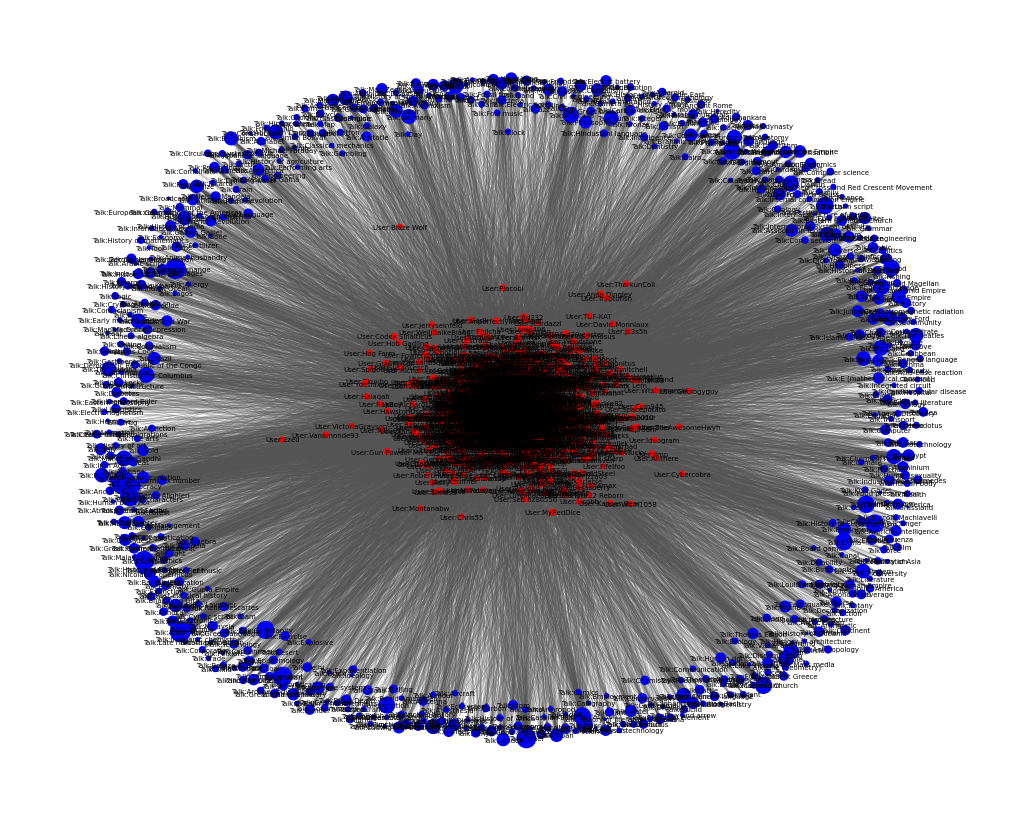

In [22]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Only keep users with a high degree
for node in page_graph.nodes(data=True):
    if "page_class" in node[1]:
        if node[1]["page_class"] == "user":
            if page_graph.out_degree(node[0]) <= 10:
                graph.remove_node(node[0])
    else:
        graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Positions (currently unused)
#pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_talk = "#0000FF"
color_user = "#FF0000"
node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw(rsubgraph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

## Basic Analysis

Number of nodes: 80391
Number of links: 160851

Highest degrees for pages:
> Overall:
Talk:United States - 2216
> Pages:
Talk:United States - 2216
Talk:Jesus - 1875
Talk:Climate change - 1768
Talk:India - 1605
Talk:Israel - 1602
Talk:Adolf Hitler - 1536
Talk:Michael Jackson - 1436
Talk:Muhammad - 1396
Talk:World War II - 1271
Talk:United Kingdom - 1191
> Users:
User:InternetArchiveBot - 801
User:Cyberbot II - 392
User:PrimeBOT - 324
User:Community Tech bot - 259
User:ScottishFinnishRadish - 235
User:Arjayay - 215
User:Cannolis - 204
User:CommonsNotificationBot - 160
User:Deacon Vorbis - 138
User:Kuyabribri - 138
Exponents:
In-degrees: 2.4607508834952707 sigma: 0.07688162544711952
Out-degrees: 1.490784046155985 sigma: 0.08416876952626716


/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


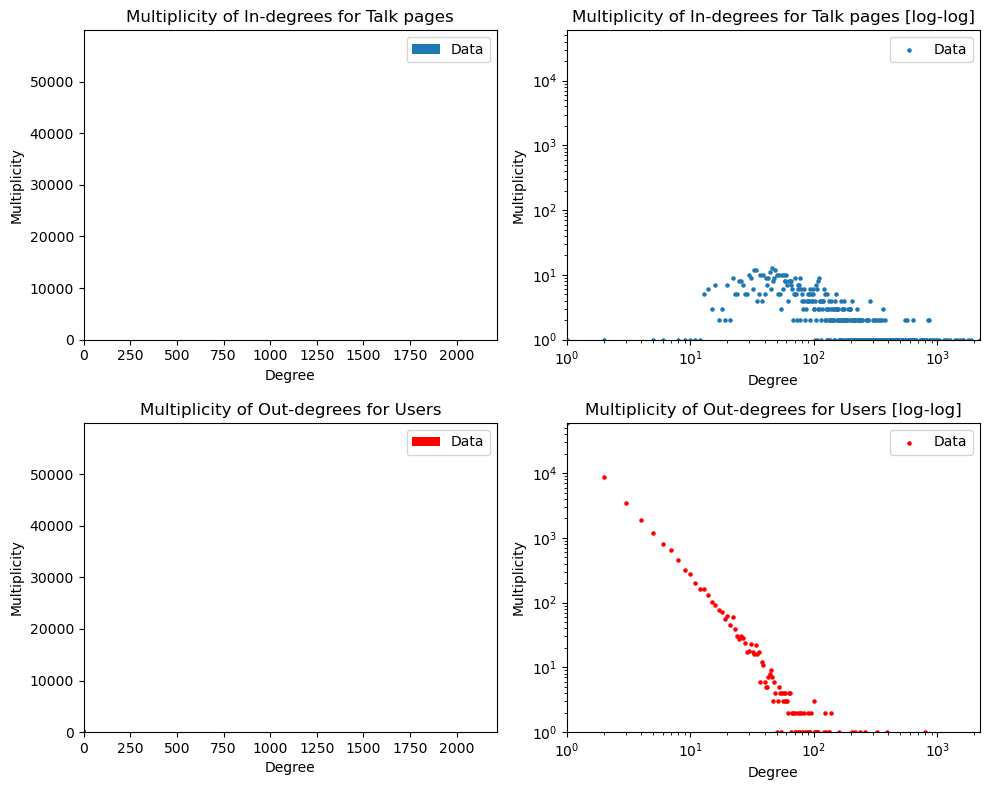

In [5]:
import pandas as p
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps

# Basic Statistics

count_nodes = len(page_graph)
count_edges = len(page_graph.edges())

# Create degree statistic dicts
degrees = dict(page_graph.degree())
in_degrees = dict(page_graph.in_degree())
out_degrees = dict(page_graph.out_degree())

talk_page_in_degrees = {k: v for k, v in in_degrees.items() if page_graph.nodes[k]["page_class"] == "talk"}
user_out_degrees = {k: v for k, v in out_degrees.items() if page_graph.nodes[k]["page_class"] == "user"}

def find_top(n, stat_dict):
    degrees_pages = []
    degrees_users = []
    top_overall = ""

    for page, degree in dict(sorted(stat_dict.items(), key=lambda item: item[1], reverse=True)).items():
        if top_overall == "":
            top_overall = page + " - " + str(degree)

        # stat dicts don't distinguish between east/west, so we'll do that here
        if len(degrees_pages) < n and page_graph.nodes[page]["page_class"] == "talk": 
            degrees_pages.append(page + " - " + str(degree))
        elif len(degrees_users) < n and page_graph.nodes[page]["page_class"] == "user":
            degrees_users.append(page + " - " + str(degree))

        if len(degrees_pages) >= n and len(degrees_users) >= n:
            break  # found all top v
    
    return degrees_pages, degrees_users, top_overall

degrees_pages, degrees_users, top_overall = find_top(10, degrees)

print("Number of nodes: " + str(count_nodes))
print("Number of links: " + str(count_edges))

print()
print("Highest degrees for pages:")
print("> Overall:")
print(top_overall)
print("> Pages:")
print("\n".join(degrees_pages))
print("> Users:")
print("\n".join(degrees_users))


# Degree multiplicities
in_degrees_counts = p.Series(talk_page_in_degrees.values()).value_counts()
out_degrees_counts = p.Series(user_out_degrees.values()).value_counts()

max_degree = max([max(in_degrees_counts.index), max(out_degrees_counts.index)])
max_multiplicity = max([max(in_degrees_counts.values), max(out_degrees_counts.values)])
range_x = range(1, max_degree + 1)

in_degrees_counts_interp = in_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()
out_degrees_counts_interp = out_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()

# Exponents
fit_in = powerlaw.Fit(in_degrees_counts.sort_index().values, verbose=False)
fit_out = powerlaw.Fit(out_degrees_counts.sort_index().values, verbose=False)

exp_in = fit_in.alpha
exp_out = fit_out.alpha

print("Exponents:")
print("In-degrees: " + str(exp_in) + " sigma: " + str(fit_in.sigma))
print("Out-degrees: " + str(exp_out) + " sigma: " + str(fit_out.sigma))

def fpl(x, a):
    return x ** (-a)

# Plots
fig, axs = plt.subplots(2, 2)

axs[0,0].bar(in_degrees_counts.index, in_degrees_counts.values, align='edge', width=1, label='Data')
#axs[0,0].plot(range_x, fpl(range_x, exp_in) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[0,0].set_title('Multiplicity of In-degrees for Talk pages')
axs[0,0].set_xlim(0, max_degree)
axs[0,0].set_ylim(0, max_multiplicity)
axs[0,0].legend()

axs[0,1].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#axs[0,1].plot(range_x, fpl(range_x, exp_in) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_title('Multiplicity of In-degrees for Talk pages [log-log]')
axs[0,1].set_xlim(1, max_degree)
axs[0,1].set_ylim(1, max_multiplicity)
axs[0,1].legend()

axs[1,0].bar(out_degrees_counts.index, out_degrees_counts.values, align='edge', width=1, label='Data', color="red")
#axs[1,0].plot(range_x, fpl(range_x, exp_out) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[1,0].set_title('Multiplicity of Out-degrees for Users')
axs[1,0].set_xlim(0, max_degree)
axs[1,0].set_ylim(0, max_multiplicity)
axs[1,0].legend()

axs[1,1].scatter(out_degrees_counts.index, out_degrees_counts.values, s=5, label='Data', color="red")
#axs[1,1].plot(range_x, fpl(range_x, exp_out) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_title('Multiplicity of Out-degrees for Users [log-log]')
axs[1,1].set_xlim(1, max_degree)
axs[1,1].set_ylim(1, max_multiplicity)
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='Degree', ylabel='Multiplicity')

fig.tight_layout()

## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)
> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)
> - What is the text you will be analyzing?
> - How will you tie networks and text together in your paper?